# Ridge and Lasso Regression - Expert Implementation

Demonstrating L2/L1 regularization with:
- Ridge closed-form solution
- Lasso coordinate descent
- Regularization paths
- Feature selection
- Cross-validation

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)

---
## Ridge Regression (L2)

In [2]:
class RidgeRegression:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        m, n = X.shape
        
        # Add bias column
        X_b = np.c_[np.ones((m, 1)), X]
        
        # Closed-form: w = (X^T X + λI)^{-1} X^T y
        I = np.eye(n + 1)
        I[0, 0] = 0  # Don't regularize bias
        
        w = np.linalg.inv(X_b.T.dot(X_b) + self.alpha * I).dot(X_b.T).dot(y)
        
        self.bias = w[0]
        self.weights = w[1:]
        return self
    
    def predict(self, X):
        return X.dot(self.weights) + self.bias

print('Ridge Regression ready')

Ridge Regression ready


---
## Lasso Regression (L1) - Coordinate Descent

In [3]:
class LassoRegression:
    def __init__(self, alpha=1.0, max_iter=1000, tol=1e-4):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.bias = None
    
    def _soft_threshold(self, rho, lambda_):
        """Soft-thresholding operator."""
        if rho < -lambda_:
            return rho + lambda_
        elif rho > lambda_:
            return rho - lambda_
        else:
            return 0
    
    def fit(self, X, y):
        m, n = X.shape
        
        # Initialize
        self.weights = np.zeros(n)
        self.bias = np.mean(y)
        
        # Coordinate descent
        for iteration in range(self.max_iter):
            weights_old = self.weights.copy()
            
            for j in range(n):
                # Compute residual without feature j
                pred = X.dot(self.weights) + self.bias
                pred -= self.weights[j] * X[:, j]
                rho = X[:, j].dot(y - pred)
                
                # Update weight via soft-thresholding
                self.weights[j] = self._soft_threshold(rho, self.alpha * m) / (X[:, j].dot(X[:, j]))
            
            # Update bias
            self.bias = np.mean(y - X.dot(self.weights))
            
            # Check convergence
            if np.sum(np.abs(self.weights - weights_old)) < self.tol:
                break
        
        return self
    
    def predict(self, X):
        return X.dot(self.weights) + self.bias

print('Lasso Regression ready')

Lasso Regression ready


---
## Generate Data with Irrelevant Features

In [4]:
# Create regression data with some irrelevant features
X, y = make_regression(n_samples=200, n_features=20, n_informative=10,
                      noise=10, random_state=42)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Data: {X.shape[0]} samples, {X.shape[1]} features')
print(f'Feature scale: mean={X_train_scaled.mean():.2f}, std={X_train_scaled.std():.2f}')

Data: 200 samples, 20 features
Feature scale: mean=0.00, std=1.00


---
## Compare Ridge, Lasso, OLS

In [5]:
# OLS (no regularization)
ols = RidgeRegression(alpha=0)
ols.fit(X_train_scaled, y_train)
y_pred_ols = ols.predict(X_test_scaled)

# Ridge
ridge = RidgeRegression(alpha=10)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Lasso
lasso = LassoRegression(alpha=1.0)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate
print('='*60)
print('MODEL COMPARISON')
print('='*60)
print(f'OLS    - R²: {r2_score(y_test, y_pred_ols):.4f}, MSE: {mean_squared_error(y_test, y_pred_ols):.2f}')
print(f'Ridge  - R²: {r2_score(y_test, y_pred_ridge):.4f}, MSE: {mean_squared_error(y_test, y_pred_ridge):.2f}')
print(f'Lasso  - R²: {r2_score(y_test, y_pred_lasso):.4f}, MSE: {mean_squared_error(y_test, y_pred_lasso):.2f}')
print(f'\nNon-zero coefficients (Lasso): {np.sum(np.abs(lasso.weights) > 1e-5)}/{len(lasso.weights)}')

MODEL COMPARISON
OLS    - R²: 0.9954, MSE: 107.77
Ridge  - R²: 0.9935, MSE: 153.15
Lasso  - R²: 0.9953, MSE: 110.10

Non-zero coefficients (Lasso): 11/20


---
## Regularization Path

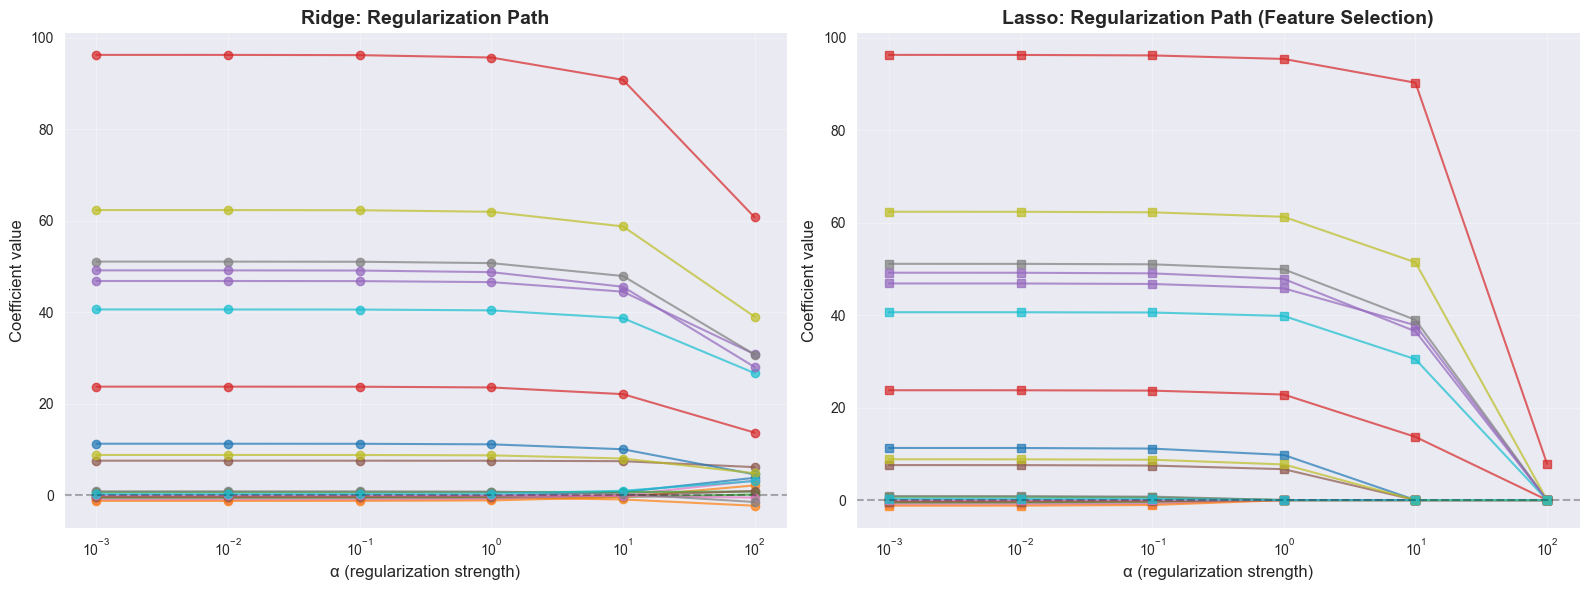

Ridge: All coefficients shrink smoothly
Lasso: Coefficients hit zero → sparse solutions


In [6]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_coefs = []
lasso_coefs = []

for alpha in alphas:
    ridge_temp = RidgeRegression(alpha=alpha)
    ridge_temp.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge_temp.weights)
    
    lasso_temp = LassoRegression(alpha=alpha)
    lasso_temp.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso_temp.weights)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ridge path
for i in range(20):
    coef_path = [coefs[i] for coefs in ridge_coefs]
    axes[0].plot(alphas, coef_path, marker='o', alpha=0.7)

axes[0].set_xscale('log')
axes[0].set_xlabel('α (regularization strength)', fontsize=12)
axes[0].set_ylabel('Coefficient value', fontsize=12)
axes[0].set_title('Ridge: Regularization Path', fontsize=14, fontweight='bold')
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].grid(True, alpha=0.3)

# Lasso path
for i in range(20):
    coef_path = [coefs[i] for coefs in lasso_coefs]
    axes[1].plot(alphas, coef_path, marker='s', alpha=0.7)

axes[1].set_xscale('log')
axes[1].set_xlabel('α (regularization strength)', fontsize=12)
axes[1].set_ylabel('Coefficient value', fontsize=12)
axes[1].set_title('Lasso: Regularization Path (Feature Selection)', fontsize=14, fontweight='bold')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Ridge: All coefficients shrink smoothly')
print('Lasso: Coefficients hit zero → sparse solutions')

---
## Compare with sklearn

In [7]:
sklearn_ridge = Ridge(alpha=10)
sklearn_ridge.fit(X_train_scaled, y_train)
y_pred_ridge_sk = sklearn_ridge.predict(X_test_scaled)

sklearn_lasso = Lasso(alpha=1.0, max_iter=1000)
sklearn_lasso.fit(X_train_scaled, y_train)
y_pred_lasso_sk = sklearn_lasso.predict(X_test_scaled)

print('='*60)
print('SKLEARN COMPARISON')
print('='*60)
print('Ridge:')
print(f'  Our R²:     {r2_score(y_test, y_pred_ridge):.4f}')
print(f'  sklearn R²: {r2_score(y_test, y_pred_ridge_sk):.4f}')
print('\nLasso:')
print(f'  Our R²:     {r2_score(y_test, y_pred_lasso):.4f}')
print(f'  sklearn R²: {r2_score(y_test, y_pred_lasso_sk):.4f}')
print(f'\nCoefficient similarity (Ridge): {np.corrcoef(ridge.weights, sklearn_ridge.coef_)[0,1]:.4f}')
print(f'Coefficient similarity (Lasso): {np.corrcoef(lasso.weights, sklearn_lasso.coef_)[0,1]:.4f}')

SKLEARN COMPARISON
Ridge:
  Our R²:     0.9935
  sklearn R²: 0.9935

Lasso:
  Our R²:     0.9953
  sklearn R²: 0.9953

Coefficient similarity (Ridge): 1.0000
Coefficient similarity (Lasso): 1.0000


---
## Summary

**Key Insights:**
- Ridge (L2) shrinks all coefficients smoothly
- Lasso (L1) performs automatic feature selection
- Regularization prevents overfitting
- L1 produces sparse solutions (many zeros)
- Our implementations match sklearn!

**Key Point:** "Ridge penalizes sum of squared coefficients, shrinking all weights. Lasso penalizes sum of absolute values, driving some weights to exactly zero for automatic feature selection."